In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

In [3]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\raw_output\\results\\jupyter_ver9copy\\models\\seq_len3_b1norm_noclip_3out_16-32-64-128.keras'
model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

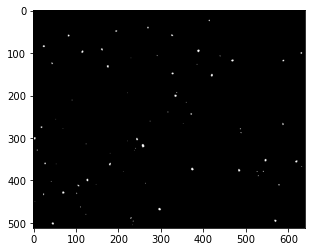

In [4]:
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\From erik\\raw output'
im_stack = get_image_stack(
    outputs=[[1,0], [2,1]], 
    folder_path=folder_path, 
    frame_im0=20, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    function_diff=[Normalize_image])

# plot_image_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,2]>0.8, cmap='gray')

In [5]:
positions = extract_positions(
    no_of_frames=48, 
    outputs=[[1,0], [2,1]], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    model=model, 
    layer=2, 
    value_threshold=0.8,
    function_diff=[Normalize_image])


In [6]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=20, threshold = 5, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=5)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0.07, list_of_plankton=list_of_plankton)

In [ ]:
# plot_and_save_track(no_of_frames=48,
#                     plankton_track=plankton_track,
#                     plankton_dont_track=plankton_dont_track,
#                     folder_path=folder_path,
#                     frame_im0=1,
#                     save_images=1,
#                     show_plankton_track = True,
#                     show_plankton_dont_track = 0,
#                     show_numbers_track = 0,
#                     show_numbers_dont_track = 0,
#                     show_numbers_specific_plankton = False,
#                     show_specific_plankton = False,
#                     specific_plankton = None,
#                     im_size_width=640, 
#                     im_size_height=512,
#                     color_plankton_track = 'b',
#                     color_plankton_dont_track = 'r',
#                     color_specific_plankton = 'w',
#                     save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\b1 report',
#                     frame_name = 'track',
#                     file_type = '.jpg')

In [ ]:
# Make_video(frame_im0=0,
#            folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\b1 report', 
#            save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\b1 report.avi', 
#            fps=7, 
#            no_of_frames=48)

[70. 76. 84. 76. 67. 77. 84. 85. 83. 78. 82. 81. 79. 78. 70. 65. 74. 75.
 75. 73. 74. 79. 70. 65. 78. 83. 77. 67. 70. 75. 70. 77. 77. 73. 76. 86.
 79. 74. 75. 75. 65. 63. 66. 65. 65. 66. 61. 53.]
[ 0.  0.  7. 10. 10. 12.  9.  9. 13.  8.  5.  4.  8.  8.  7.  8.  8.  5.
  5.  1.  5. 10.  3.  3.  4.  4.  2.  4.  4.  2.  1.  1.  2.  3.  0.  0.
  0.  1.  2.  1.  2.  2.  0.  2.  2.  0.  2. 17.]


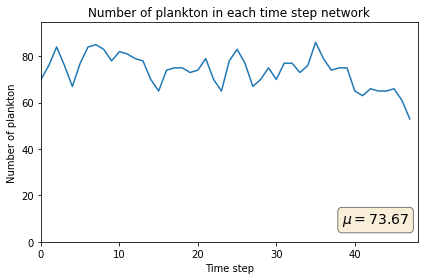

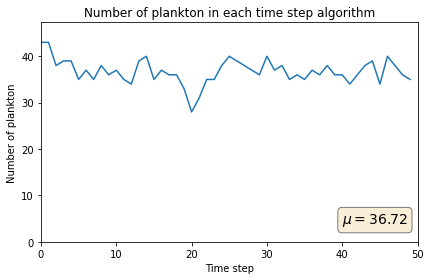

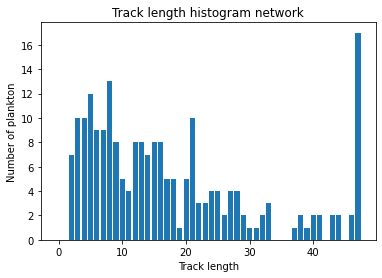

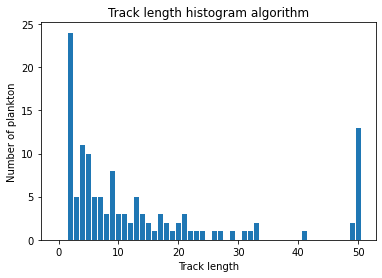

In [7]:
import xml.etree.ElementTree as ET

def plot_statistics(found_plankton_at_timestep, title):
    cropped_finds = found_plankton_at_timestep[np.nonzero(found_plankton_at_timestep)[0]]

    ax = plt.figure()
    plt.plot(range(len(cropped_finds)), cropped_finds)
    plt.xlabel('Time step')
    plt.ylabel('Number of plankton')
    plt.title(title)
    plt.tight_layout()
    mu = np.mean(cropped_finds)
    
    plt.axis([0, len(cropped_finds), 0, max(cropped_finds)*1.1])
    
    textstr = r'$\mu=%.2f$' % (mu, )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.25, textstr, fontsize=14,
            verticalalignment='top', bbox=props)
    
def get_found_plankton_at_timestep(plankton_track):
    no_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    found_plankton_at_timestep = np.zeros(no_timesteps)

    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        for i in where_list[0]:
            found_plankton_at_timestep[i] += 1
    return found_plankton_at_timestep

def get_found_plankton_from_xml(path, no_timesteps, var_str):
    tree = ET.parse(path)
    root = tree.getroot()


    found_plankton_at_timestep = np.zeros(no_timesteps)

    for particle in root.iter():
        my_dict = particle.attrib
        if var_str in my_dict:
            found_plankton_at_timestep[int(float(my_dict[var_str]))] += 1
    return found_plankton_at_timestep


def plot_bars(track_durations, title):
    plt.figure()
    plt.bar(range(len(track_durations)), track_durations)
    
    plt.xlabel('Track length')
    plt.ylabel('Number of plankton')
    plt.title(title)



def get_track_durations(plankton_track):
    no_of_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    track_durations = np.zeros(no_of_timesteps)
    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        track_start = np.min(where_list)
        track_end = np.max(where_list)

        track_durations[track_end-track_start] += 1
    return track_durations


found_plankton_at_timestep = get_found_plankton_at_timestep(plankton_track)     
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step network')
print(found_plankton_at_timestep)

path = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\raw output_Tracks.xml"
no_timesteps = 51
found_plankton_at_timestep = get_found_plankton_from_xml(path, no_timesteps, 't')
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step algorithm')


track_durations = get_track_durations(plankton_track)
plot_bars(track_durations, 'Track length histogram network')
print(track_durations)

track_durations = get_found_plankton_from_xml(path, no_timesteps, 'nSpots')
plot_bars(track_durations, 'Track length histogram algorithm')
